In [43]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# chrome://bookmarks/?q=xgboost

In [44]:
dateTimeCols=['open_datetime','response_datetime','resolved_datetime','close_datetime']
cateFeatures=['product_type','brand','incident_type','service_type','is_failure_type','sla']
numericFeatures=['count_detail','open_to_close_hour','response_to_resolved_hour','open_to_response_hour','resolved_to_close_hour']
colLabel='severity_label'


colFeatures=cateFeatures+numericFeatures
cols=[colLabel]+colFeatures
print(cols)

to_date='2023-12-31'

['severity_label', 'product_type', 'brand', 'incident_type', 'service_type', 'is_failure_type', 'sla', 'count_detail', 'open_to_close_hour', 'response_to_resolved_hour', 'open_to_response_hour', 'resolved_to_close_hour']


# Load and Prepare Data

In [45]:
df_incident = pd.read_csv('incident_data.csv',parse_dates=dateTimeCols)
print(f"Incident From {df_incident['open_datetime'].min()} To {df_incident['open_datetime'].max()}")
print(df_incident.info())

Incident From 2020-03-15 13:36:00 To 2023-02-01 06:40:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   severity_label             2096 non-null   object        
 1   sla                        2096 non-null   object        
 2   id                         2096 non-null   int64         
 3   incident_no                2096 non-null   object        
 4   product_type               2096 non-null   object        
 5   brand                      2096 non-null   object        
 6   mode                       2096 non-null   object        
 7   incident_type              2096 non-null   object        
 8   status                     2096 non-null   object        
 9   service_type               2096 non-null   object        
 10  is_failure_type            2096 non-null   bool          
 11  count_detail

In [46]:
df_incident=df_incident.query("open_datetime<=@to_date")
df_incident=df_incident[cols]
print(df_incident.info())
df_incident.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2095
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_label             2096 non-null   object 
 1   product_type               2096 non-null   object 
 2   brand                      2096 non-null   object 
 3   incident_type              2096 non-null   object 
 4   service_type               2096 non-null   object 
 5   is_failure_type            2096 non-null   bool   
 6   sla                        2096 non-null   object 
 7   count_detail               2096 non-null   int64  
 8   open_to_close_hour         2095 non-null   float64
 9   response_to_resolved_hour  2095 non-null   float64
 10  open_to_response_hour      2096 non-null   float64
 11  resolved_to_close_hour     2094 non-null   float64
dtypes: bool(1), float64(4), int64(1), object(6)
memory usage: 198.5+ KB
None


,severity_label,product_type,brand,incident_type,service_type,is_failure_type,sla,count_detail,open_to_close_hour,response_to_resolved_hour,open_to_response_hour,resolved_to_close_hour
2091,Minor,Storage,YIP,General Incident,Request,False,24x7 6Hrs Resolution Time,1,67.250000,0.000000,67.250000,0.000000
2092,Major,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,3,365.316667,169.016667,2.633333,193.666667
2093,Major,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,2,20.166667,4.533333,0.550000,15.083333
2094,Major,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,1,23.783333,0.000000,23.783333,0.000000
2095,Major,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,2,31.150000,28.466667,1.450000,1.233333


# Split features and class

In [47]:
features=[ col for col in list(df_incident.columns) if  col!=colLabel ]
X = df_incident.loc[:,features]

cate_features=[ col for col in features if  col not in numericFeatures ]
for cate_col in cate_features:
  X[cate_col]=X[cate_col].astype("category")

print(X.info())
X.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2095
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   product_type               2096 non-null   category
 1   brand                      2096 non-null   category
 2   incident_type              2096 non-null   category
 3   service_type               2096 non-null   category
 4   is_failure_type            2096 non-null   category
 5   sla                        2096 non-null   category
 6   count_detail               2096 non-null   int64   
 7   open_to_close_hour         2095 non-null   float64 
 8   response_to_resolved_hour  2095 non-null   float64 
 9   open_to_response_hour      2096 non-null   float64 
 10  resolved_to_close_hour     2094 non-null   float64 
dtypes: category(6), float64(4), int64(1)
memory usage: 112.7 KB
None


,product_type,brand,incident_type,service_type,is_failure_type,sla,count_detail,open_to_close_hour,response_to_resolved_hour,open_to_response_hour,resolved_to_close_hour
2091,Storage,YIP,General Incident,Request,False,24x7 6Hrs Resolution Time,1,67.250000,0.000000,67.250000,0.000000
2092,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,3,365.316667,169.016667,2.633333,193.666667
2093,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,2,20.166667,4.533333,0.550000,15.083333
2094,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,1,23.783333,0.000000,23.783333,0.000000
2095,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,2,31.150000,28.466667,1.450000,1.233333


In [48]:
Y = df_incident.loc[:,[colLabel]]
Y[colLabel]=Y[colLabel].astype("category")
print(Y.info())
Y.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2095
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   severity_label  2096 non-null   category
dtypes: category(1)
memory usage: 18.6 KB
None


,severity_label
2091,Minor
2092,Major
2093,Major
2094,Major
2095,Major


# Encode string class values as integers

In [49]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
ylabelEncoded = label_encoder.transform(Y)
print(ylabelEncoded[-5:])

[3 2 2 2 2]


D:\ProgramData\Anaconda3\envs\dev_ml_local\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\Anaconda3\envs\dev_ml_local\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


# Split Train and Test Data

In [50]:
seed = 7
test_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(X, ylabelEncoded, test_size=test_size, random_state=seed)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(1781, 11) (315, 11)
(1781,) (315,)


In [51]:
print(y_train[:2])
X_train[:2]

[3 0]


,product_type,brand,incident_type,service_type,is_failure_type,sla,count_detail,open_to_close_hour,response_to_resolved_hour,open_to_response_hour,resolved_to_close_hour
2023,Storage,NetApp,General Incident,Request,False,24x7 4Hrs Response Time,1,2.316667,0.166667,0.150000,2.0
841,Software,Trend Micro,General Incident,Request,False,24x7 4Hrs Response Time,1,21.333333,2.800000,18.533333,0.0


# XGBoost Fit model no training data and Predict

In [52]:
# Supported tree methods are `gpu_hist`, `approx`, and `hist`.
model_xg = XGBClassifier(enable_categorical=True,tree_method="hist")
model_xg.fit(X_train, y_train)
print(model_xg)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)


In [53]:
y_pred_xg = model_xg.predict(X_test)
predictions_xg = [round(value) for value in y_pred_xg]

accuracy_xg = accuracy_score(y_test, predictions_xg)
print("XGBoost Accuracy: %.2f%%" % (accuracy_xg * 100.0))

XGBoost Accuracy: 78.73%


In [ ]:
# In [7]: le.inverse_transform(predictions[:5])
# Out[7]: 
# array(['Iris-virginica', 'Iris-setosa', 'Iris-setosa', 'Iris-versicolor',
#        'Iris-virginica'], dtype=object)

# Feature Important

In [16]:
import matplotlib.pyplot  as plt
feature_series=pd.Series(model_xg.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_series

service_type                 0.522336
response_to_resolved_hour    0.067324
open_to_close_hour           0.066795
brand                        0.060688
sla                          0.043261
incident_type                0.043205
open_to_response_hour        0.041632
is_failure_type              0.040812
count_detail                 0.040290
resolved_to_close_hour       0.036982
product_type                 0.036676
dtype: float32

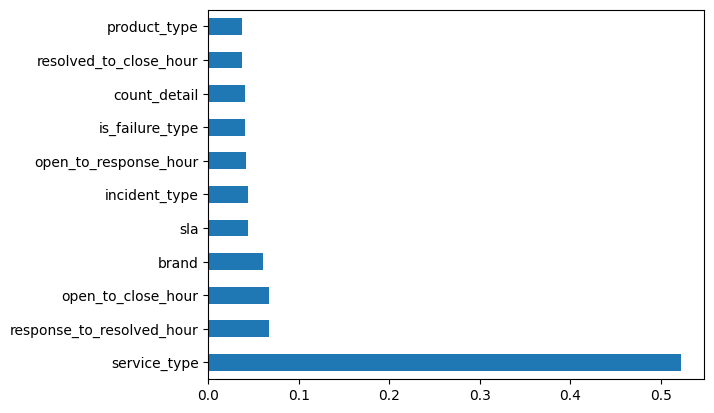

In [17]:
feature_series.plot(kind='barh')
plt.show()